<html><font size=6><B>3η εργαστηριακή άσκηση</B><BR>
    <BR><B>Link prediction - Πρόβλεψη συνδέσμων</B></BR>
    </font></html>

<html><font size=4><B>1. Κατασκευή γράφου και προεργασία για την πρόβλεψη συνδέσμων</B></font>
    <li><B>1(i).</B> Χρησιμοποιήστε το dataset <a href="http://konect.cc/networks/dbpedia-similar/"> Similarities (DBpedia)</a>, για να κατασκευάσετε τον μη κατευθυνόμενο (undirected) γράφο $G$ <a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]</a>,<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]</a>. Οι κόμβοι του γράφου αναπαριστούν σελίδες της Wikipedia και οι ακμές σχέση ομοιότητας μεταξύ τους. Στην σελίδα <a href="http://konect.cc/networks/dbpedia-similar/"> KONECT (DBpedia)</a> μπορείτε να βρείτε πληροφορίες για τις ιδιότητες του γράφου.</a><BR>
        <B><U>Υπόδειξη:</U></B> Μπορείτε να ελέγξετε προγραμματιστικά αν το dataset περιέχει διπλότυπα των ακμών με την ίδια ή αντίστροφη σειρά (π.χ. ακμές (a,b) και (b,a)), και να λάβετε υπ' όψιν σας αυτήν σας την παρατήρηση, όπου τυχόν χρειαστεί, στην ερώτηση 2.<BR></html>

In [1]:
%matplotlib inline
%pip install --upgrade node2vec
%pip install --upgrade scikit-learn
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import heapq

edges = set()
edge=tuple()
check = False

with open('out.dbpedia-similar', 'r') as file:
    for line in file:
        if not line.startswith('%'):
                first,sec = map(int, line.split())
                edge = tuple(sorted((first, sec)))
                if edge in edges :
                    check=True
                    print('There are duplictaes')
                    break
                else :
                    edges.add(edge)
    if check == False :
        print('There are no duplicates')
    
    
G = nx.read_edgelist("out.dbpedia-similar",create_using=nx.Graph(), nodetype=int, comments='%')
G.remove_edges_from(nx.selfloop_edges(G))


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
There are no duplicates


 <li><B>1(ii).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G$.</li><BR>

In [2]:
def stats_of(G):
    nodes_count = G.number_of_nodes()
    edges_count = G.number_of_edges()
    average_degree = 2 * edges_count / nodes_count
    connected_components_count = nx.number_connected_components(G)

    print(f"Nodes count: {nodes_count}")
    print(f"Edges count: {edges_count}")
    print(f"Average degree: {average_degree}")
    print(f"Connected components count: {connected_components_count}")
    
    return nodes_count, edges_count, average_degree, connected_components_count

print(f"- Initial graph stats")
initial_nodes_count, initial_edges_count, initial_average_degree, initial_connected_components_count = stats_of(G)


- Initial graph stats
Nodes count: 430
Edges count: 564
Average degree: 2.6232558139534885
Connected components count: 95


<li><B>1(iii). </B>Υπολογίστε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix). Δώστε επίσης τον αριθμό τους. Λάβετε υπ' όψιν σας ότι ο γράφος είναι μη κατευθυνόμενος και δεν χρειάζεται να διατρέξετε ολόκληρο τον πίνακα γειτνίασης.</li><BR>

In [3]:
adjacency_matrix = nx.adjacency_matrix(G)
rows, columns = adjacency_matrix.shape
unconnected_pairs = []
sum=0
for i in range(rows):
    for j in range(i+1,columns):
        if adjacency_matrix[i, j] == 0:
            sum += 1
            unconnected_pairs.append((i+1, j+1))
print('Number of unnconnected pairs:',sum)


C:\Users\User\AppData\Local\Temp\ipykernel_2612\2824088549.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)


Number of unnconnected pairs: 91671


<li><B>1(iv).</B> Υπολογίστε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος). Υπόδειξη: Ελέγχετε επίσης ότι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων (εφόσον δεν υπάρχει ξεχωριστό αρχείο μόνο με κόμβους στο dataset). Δώστε επίσης τον αριθμό των ακμών (removable edges) που μπορούν να αφαιρεθούν υπό αυτές τις προϋποθέσεις.</li><BR>

In [4]:
mst = nx.minimum_spanning_tree(G)
removable_edges = set(G.edges) - set(mst.edges)

connected_components_G = list(nx.connected_components(G))
connected_components_mst = list(nx.connected_components(mst))

# removable edges: check splitting and number of nodes

if ( G.number_of_nodes()== mst.number_of_nodes()) and ( connected_components_G== connected_components_mst): 
    print('Removable edges count:',len(removable_edges))
    print('Same connected components and same number of nodes.')
    
removables = list(removable_edges)

Removable edges count: 229
Same connected components and same number of nodes.


<li><B>1(vα).</B> Κατασκευάστε dataframe που συνενώνει τις απαντήσεις των ερωτημάτων 1(iii) και 1(iv) (unconnected+removables). Χρησιμοποιήστε την μεταβλητή $link$ που θα παίρνει τιμή 1 ή 0 ανάλογα με την ύπαρξη συνδέσμου ή μη. To dataframe αυτό συγκεντρώνει τα θετικά και αρνητικά δείγματα για την πρόβλεψη των μελλοντικών συνδέσεων (link: target variable). <BR>
    <li><B>1(vβ).</B> Κατασκευάστε τον γράφο $G'$ που προκύπτει από την αφαίρεση από τον γράφο $G$ των ακμών του ερωτήματος 1(iv). <BR>
    <li><B>1(vγ).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G'$.</li><BR>

In [5]:
df_unconnected = pd.DataFrame({'edge': unconnected_pairs, 'link': 0})
df_removables = pd.DataFrame({'edge': removables, 'link': 1})
df_merged = pd.concat([df_unconnected, df_removables], ignore_index=True)
print(df_merged)

G_reduced = G.copy()
G_reduced.remove_edges_from(removables)

G_reduced_nodes_count, G_reduced_edges_count, G_reduced_average_degree, G_reduced_connected_components_count = stats_of(G_reduced)


#dataframe of removable edges (they will function as positive samples)
#...['link'] = 1  #uncomment and complete

#dataframe of unconnected node pairs (they will function as negative samples)
#...['link'] = 0 # uncomment and complete

#merge in one dataframe

#build graph G'=G_reduced

             edge  link
0          (1, 6)     0
1          (1, 7)     0
2          (1, 8)     0
3          (1, 9)     0
4         (1, 10)     0
...           ...   ...
91895  (342, 343)     1
91896  (335, 337)     1
91897  (334, 339)     1
91898  (400, 403)     1
91899  (336, 345)     1

[91900 rows x 2 columns]
Nodes count: 430
Edges count: 335
Average degree: 1.558139534883721
Connected components count: 95


<html><font size=4><B>2. Εισαγωγή σε similarity-based μετρικές για Link prediction</B></font><BR><BR>
     <li> Η μετρική <B>Jaccard Coefficient (JC)</B> των κόμβων ${u}$ και ${v}$ ορίζεται ως $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$, όπου ${\Gamma(u)}$ είναι το σύνολο των γειτονικών κόμβων του κόμβου ${u}$.  <B></B>
        <li> Η μετρική <B>Preferential Αttachment (PA)</B> των κόμβων $u$ και $v$ ορίζεται ως $|\Gamma(u)| |\Gamma(v)|$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li>
        <li> Η μετρική <B>Resource Allocation (RA)</B> των κόμβων $u$ και $v$ ορίζεται ως $\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li><BR><BR>
    <li><B>2(i).</B> Για τον γράφο $G'$, που κατασκευάσατε στο ερώτημα 1(vβ), υπολογίστε την μετρική <B>Jaccard Coefficient (JC)</B>.  <u><a href="https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html?highlight=link%20prediction">Χρησιμοποιήστε την υλοποιημένη συνάρτηση του λογισμικού NetworkX.<a></u> <BR><BR>
    <li><B>2(ii). </B>Δώστε τις $k$ ακμές με την υψηλότερη τιμή μετρικής $JC$, όπου $k$ ο $Α.Μ.$ σας $mod$ $10$. Για $Α.Μ.$ λήγοντα σε $0$ δώστε τις $10$ ακμές με την υψηλότερη τιμή μετρικής.
        (Για την σύγκριση μεταξύ διαφορετικών μετρικών προτιμάται η εύρεση των $k$ επικρατέστερων συνδέσμων, αφού οι μετρικές επιστρέφουν διαφορετικό εύρος τιμών.)</li><BR>
    <li><B>2(iii). </B>Προσδιορίστε για την μέτρηση της απόδοσης της μετρικής $JC$ τα μεγέθη $Precision$, $Recall$ και $Accuracy$ και αναπαραστήστε τα γραφικά για τιμές κατωφλίου: $0.1$, $0.15$, $0.25$, $0.5$, $1.0$.  <BR><BR>
    $Precision=\frac{TP}{TP+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα <BR>
    $Recall=\frac{TP}{TP+FN}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα</li> 
    $Accuracy=\frac{TP+TN}{TP+FN+TN+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $TN$: αληθώς αρνητικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα</li><BR><BR>
        <B><U>Υπόδειξη:</U></B>
        Θετικό θεωρήστε ένα αποτέλεσμα, αν η μετρική $JC$ υπερβαίνει μια τιμή κατωφλίου (>=). Αρνητικό θεωρήστε το στην αντίθετη περίπτωση.
        <li>Αληθώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά (η τιμή της $JC$ υπερβαίνει την τιμή κατωφλίου) και πράγματι θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iv)).</li>
        <li>Αληθώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά και πράγματι δεν θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iii)).</li>
        <li>Ψευδώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά, ενώ δεν θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Ψευδώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά, ενώ θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Το άθροισμα $TN+FP$ πρέπει κάθε φορά να σας δίνει όλες τις ασύνδετες ακμές του γράφου $G$.</li>   
<li>Από το ερώτημα 1(iii) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες δεν θα υπάρξουν συνδέσεις.</li> <li>Από το ερώτημα 1(iv) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες θα υπάρξουν συνδέσεις.</li><BR></html>

1 ) Jaccard coefficient for nodes  2 and 4 is 1.0 .
2 ) Jaccard coefficient for nodes  21 and 147 is 1.0 .
3 ) Jaccard coefficient for nodes  21 and 312 is 1.0 .
4 ) Jaccard coefficient for nodes  23 and 25 is 1.0 .
5 ) Jaccard coefficient for nodes  23 and 27 is 1.0 .
6 ) Jaccard coefficient for nodes  23 and 31 is 1.0 .
7 ) Jaccard coefficient for nodes  23 and 33 is 1.0 .
8 ) Jaccard coefficient for nodes  23 and 34 is 1.0 .
There are 311 couples of nodes with a jc of 1.0 in total


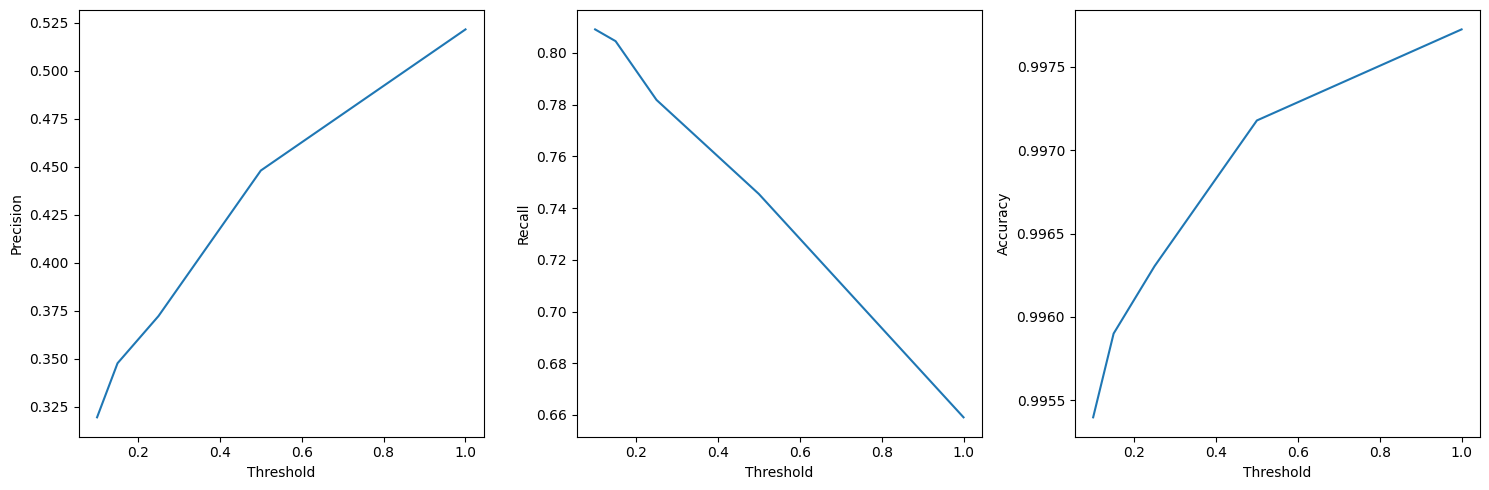

In [9]:
k = 3119878 % 10
jc_list = [(u, v, p) for u, v, p in nx.jaccard_coefficient(G_reduced)]
def k_largest_JC(top,G):  
        sum = 0
        num=0
        all_jc = []
        result = []
        for a,b,c in jc_list:
            if c == 1 :
                sum=sum+1
        for i in range(top):
            max_tuple = max(jc_list, key=lambda x: x[2])
            result.append(max_tuple) 
            jc_list.remove(max_tuple)
            a,b,c = max_tuple
        for u,v,p in result:
            num=num+1
            print(num,') Jaccard coefficient for nodes ',u,'and',v,'is',p,'.')
        print('There are',sum,'couples of nodes with a jc of 1.0 in total')

def JCfunction(threshold) :    
    TP, FP, FN, TN = 0, 0, 0, 0
    for a,b,c in jc_list:
        if c >= threshold:
            if (a, b) in removables:
                TP += 1
            elif (a, b) in unconnected_pairs:
                FP += 1

        elif c < threshold:
            if (a, b) in removables:
                FN += 1
            elif (a, b) in unconnected_pairs:
                TN += 1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    return threshold,precision, recall, accuracy
           
k_largest_JC(k,G_reduced)
thresholds = [0.1,0.15,0.25,0.5,1.0]
precisions = []
recalls = []
accuracies = []
for i in thresholds:
    th,p,r,a = JCfunction(i)
    precisions.append(p)
    recalls.append(r)
    accuracies.append(a)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
data = zip([ax1, ax2, ax3],
           [precisions, recalls, accuracies],
           ['Precision', 'Recall', 'Accuracy'])

for ax, metric, title in data:
    ax.plot(thresholds, metric)
    ax.set_xlabel('Threshold')
    ax.set_ylabel(title)
plt.tight_layout()
plt.show()
    




<html><font size=4><B>3. Πρόβλεψη συνδέσμων βάσει similarity-based μετρικών</B></font>    
        <li><B>3(i).</B> Προτείνετε μια τουλάχιστον μέθοδο, για να εξερευνήσουμε και να εκφράσουμε μέσα από τα πακέτα NumPy ή SciPy ή Pandas την συσχέτιση (correlation) μεταξύ των τιμών των μετρικών <B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B> για τον μειωμένο γράφο $G'$. Σημ.: Δεν χρειάζεται κάποια υλοποίηση, μόνο αναφορά της μεθόδου συσχέτισης και επεξήγηση της επιλογής σας.
     <li><B>3(ii).</B> Εργαστείτε πάνω σε <B><U>αντίγραφο</U></B> του dataframe που κατασκευάσατε στο ερώτημα 1(vα) (unconnected+removables). Δημιουργήστε στήλη (column) με τις ακμές του γράφου και θέστε την ως index του dataframe. Στο dataframe θα προσθέσετε ως στήλες τις τιμές των μετρικών (<B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B>) για τον μειωμένο γράφο $G'$. Οι τιμές των μετρικών μπορούν να υπολογιστούν με τις συναρτήσεις του πακέτου NetworkX.</li>   </font></html>
    
    |       | link  |Jacc.Coeff.|Pr.Attachment| Resource Allocation|
    |-------|-------|-----------|-------------|--------------------|
    |(1, 6) |  0    |  0.333333 |     32      |    0.700000        |
    |(1, 46)|  0    |  0.200000 |      8      |    0.166667        |

# 3 (i) Απάντηση

Για να συσχετήσουμε τις μετρικές JC, PA, RA μπορούμε να χρησιμοποιήσουμε το Pearson Correlation Coefficient.Αυτό γίνεται εφικτό απο το SCiPy και ειδικότερα απο το scipy.stats ως scipy.stats.pearsonr(x, y).correlation ή απο το Pandas ως pandas.corr(x, y) όπου υπάρχει σαν παράμετρος η method η οποία εαν δεν οριστεί σε κάτι άλλο είναι default σε Pearson. Ο Συντελεστής Συσχέτισης Pearson προσμετρά την γραμμική σχέση μεταξύ δύο χαρακτηριστικών. Είναι ο λόγος της συνδιακύμανσης των x και y προς το γινόμενο των τυπικών αποκλίσεων τους. Συχνά συμβολίζεται με το γράμμα r και ονομάζεται r του Pearson.




In [8]:
k = 3119878 % 10
df_merged_3 = df_merged.copy()
#replicate of the dataframe "unconnected+removables"---dataframe will be used again in (4)

In [9]:

jaccard_coefficient = [p for u, v, p in nx.jaccard_coefficient(G_reduced)]
preferential_attachment = [p for u, v, p in nx.preferential_attachment(G_reduced)]
resource_allocation = [p for u, v, p in nx.resource_allocation_index(G_reduced)]

df_merged_3 = df_merged_3.assign(jaccard_coefficient_=jaccard_coefficient)
df_merged_3 = df_merged_3.assign(preferential_attachment_=preferential_attachment)
df_merged_3 = df_merged_3.assign(resource_allocation_=resource_allocation)

df_merged_3

#dataframe for similarity-based measurement values
#Jaccard Coefficient

#Preferential Attachment

#Resource Allocation

,edge,link,jaccard_coefficient_,preferential_attachment_,resource_allocation_
0,"(1, 6)",0,0.166667,12,0.5
1,"(1, 7)",0,0.000000,4,0.0
2,"(1, 8)",0,0.000000,12,0.0
3,"(1, 9)",0,0.000000,12,0.0
4,"(1, 10)",0,0.000000,8,0.0
...,...,...,...,...,...
91895,"(342, 343)",1,0.000000,1,0.0
91896,"(335, 337)",1,0.000000,2,0.0
91897,"(334, 339)",1,0.000000,1,0.0
91898,"(400, 403)",1,0.000000,1,0.0


<li><B>3(iiiα).</B> Χρησιμοποιήστε τον Random Forest Classifier και το αντίγραφο dataframe που κατασκευάσατε στο ερώτημα 3(ii), για να προβλέψετε συνδέσεις. Συμπληρώστε στον κώδικα: τα features ($X$), την target variable ($y$) και τα ορίσματα της συνάρτησης $fit$ για το training του μοντέλου.</li>
<li><B>3(iiiβ).</B> Δώστε τις ($A.M$ $mod$ $10$) πρώτες προβλέψεις και την ακρίβεια ($accuracy$) του μοντέλου. </li>
<li><B>3(iiiγ).</B>Υπολογίστε την πιθανότητα να συνδεθούν οι κόμβοι ($1$,$47$) βάσει του μοντέλου σας. </li>  

In [10]:
#uncomment whole cell
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

X = df_merged_3[['jaccard_coefficient_', 'preferential_attachment_', 'resource_allocation_']]


y = df_merged_3[['link']]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)


y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
# classifier
classifier = RandomForestClassifier()


mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)


parameters = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]} 
model = GridSearchCV(classifier, param_grid = parameters) 

model.fit(X_train_scaled, y_train)

#X =             #features, uncomment and complete
#y = ...['link'] #target, uncomment and complete

#X_train, X_test, y_train, y_test = train_test_split(, , random_state = 0) #uncomment and complete

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 100]})

In [8]:
#uncomment whole cell
#classifier = RandomForestClassifier()   

#from sklearn.preprocessing import MinMaxScaler 
#mm_scaler = MinMaxScaler() 
#X_train_scaled = mm_scaler.fit_transform(X_train)
#X_test_scaled = mm_scaler.transform(X_test)

#parameters = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]} 
#model = GridSearchCV(classifier, param_grid = parameters) 

In [9]:
#model.fit(X_train_scaled, )#train the model, uncomment and complete

In [11]:
y_pred = model.predict(X_test_scaled)

print(f"- First {k} predictions:")
for index, prediction in enumerate(y_pred[:k]):
    print(f"#{index+1}: {prediction}")

print(f"\n- Accuracy: {accuracy_score(y_test, y_pred)}")

- First 8 predictions:
#1: 0
#2: 0
#3: 0
#4: 0
#5: 0
#6: 0
#7: 0
#8: 0

- Accuracy: 0.9976060935799782


In [12]:

edge = df_merged_3.loc[df_merged_3['edge'] == (1, 47)]
x_edge = edge[['jaccard_coefficient_', 'preferential_attachment_', 'resource_allocation_']]
scaled_x_edge = mm_scaler.transform(x_edge)
probability = model.predict_proba(scaled_x_edge)

print(f"Probability of edge (1, 47) being a link: {probability[0][1]}")

Probability of edge (1, 47) being a link: 0.0001026694045174538


<html><font size=4><B>4. Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks) </B></font><BR><BR>
    <li><B>4(i).</B> Εξάγετε τα χαρακτηριστικά (features) του γράφου $G'$, που προέκυψε από την αφαίρεση των ακμών. Για τον σκοπό αυτό χρησιμοποιήστε τον αλγόριθμο <B>Node2vec</B> <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a>. Ο αλγόριθμος αντιστοιχίζει τους κόμβους του γράφου μέσω τυχαίων περιπάτων (biased 2nd order random walks) σε ένα χώρο μικρού αριθμού διαστάσεων (low dimensional space) διατηρώντας την μεταξύ τους γειτνίαση.
        <BR>Για την επιλογή των παραμέτρων: 
            <li>p - παράμετρος τυχαίων περιπάτων p που καθορίζει την πιθανότητα “1/p” επιστροφής στον κόμβο προέλευσης (source node), </li>
                <li>q - παράμετρος τυχαίων περιπάτων q που καθορίζει την πιθανότητα  “1/q” μετακίνησης σε κόμβο μακριά από τον κόμβο προέλευσης (source node), </li>
                 <li>dimensions - πλήθος διαστάσεων των Node2Vec embeddings, </li>
                     <li>num_walks - αριθμός περιπάτων από κάθε κόμβο, </li>
                         <li>walk_length - μήκος τυχαίου περιπάτου, </li>
                             <li>window_size - μέγεθος παραθύρου context για τον αλγόριθμο Word2Vec, </li><li>num_iter - αριθμός SGD επαναλήψεων (epochs), </li>
            <li>workers - αριθμός workers για τον Word2Vec,</li>
            χρησιμοποιήστε τις τιμές:   </html>
   
                   

 |   p   |   q   | dimensions|  num_walks  |walk_length |window_size|        workers            |
 |-------|-------|-----------|-------------|------------|-----------|---------------------------|
 |  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

In [13]:

from node2vec import Node2Vec   
import multiprocessing          
node2vec_walker = Node2Vec(
    G_reduced, 
    p=1.0, 
    q=1.0, 
    dimensions=128, 
    num_walks=10, 
    walk_length=80, 
    workers=multiprocessing.cpu_count())

n2v_model = node2vec_walker.fit(window=10, min_count=1)
#generate walks
#node2vec_walker = Node2Vec(, , , , , , ) #uncomment and complete

#train node2vec model
#n2v_model = node2vec_walker.fit(window= , min_count=1) #uncomment and complete

Computing transition probabilities:   0%|          | 0/430 [00:00<?, ?it/s]

<html><font>
    <li><B>4(ii).</B> Εφαρμόστε τον αλγόριθμο Random Forest Classifier, για να προβλέψετε τις συνδέσεις.</li><BR>
    <li><B>4(iii).</B> Υπολογίστε την ακρίβεια ($accuracy$) του μοντέλου. </li><BR></font></html>

In [15]:
X = [(n2v_model.wv[str(i)] + n2v_model.wv[str(j)]) for i, j in df_merged_3['edge']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
#apply trained Node2Vec model on each node pair of the dataframe "unconnected+removables"
#uncomment:
#x = [(n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) for i,j in zip(df_with_target_var['node_1'], df_with_target_var['node_2'])]

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=2, random_state=0)

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(, , random_state = 0)  #uncomment and complete

In [16]:
y_pred = classifier.predict(X_test)
print(f"- Accuracy: {accuracy_score(y_test, y_pred)}")
#uncomment whole cell
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score

#classifier = RandomForestClassifier(max_depth=2, random_state=0) 
#classifier.fit()   #uncomment and complete

- Accuracy: 0.9976060935799782


<html><font size=4> <B><U>Ερώτηση bonus (+10/100)</U><B>: </font>Για τους binary operators για learning των edge features με τον αλγόριθμο Node2Vec που αναφέρονται στο <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a> ((α) Average, (β) Hadamard, (γ) Weighted-L1 και (δ) Weighted-L2) τροποποιήστε τoν κώδικά σας και σημειώστε τις παρατηρήσεις σας ως προς την απόδοση του αλγορίθμου.</font></html>

In [17]:
X_average = [(n2v_model.wv[str(i)] + n2v_model.wv[str(j)]) / 2 for i, j in df_merged_3['edge']]
X_hadamard = [(n2v_model.wv[str(i)] * n2v_model.wv[str(j)]) for i, j in df_merged_3['edge']]
X_l1 = [np.abs(n2v_model.wv[str(i)] - n2v_model.wv[str(j)]) for i, j in df_merged_3['edge']]
X_l2 = [(n2v_model.wv[str(i)] - n2v_model.wv[str(j)]) ** 2 for i, j in df_merged_3['edge']]

accuracies = []

for x in [X_average, X_hadamard, X_l1, X_l2]:
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
    classifier = RandomForestClassifier(max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

operators = ['Average', 'Hadamard', 'Weighted-L1', 'Weighted-L2']
for operator, accuracy in zip(operators, accuracies):
    print(f"- Accuracy for {operator} operator: {accuracy}")

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exa

- Accuracy for Average operator: 0.9976060935799782
- Accuracy for Hadamard operator: 0.9976060935799782
- Accuracy for Weighted-L1 operator: 0.9976060935799782
- Accuracy for Weighted-L2 operator: 0.9976060935799782


#
Ανεξάρτητα απο τον operator η ακρίβεια είναι ίδια και πολύ υψηλή της τάξεως του 99.7%.


<html><font size=4><B><U>Βιβλιογραφία:</U></B><BR></font>
<a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]	Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.</a><BR>
<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]	Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722–735, 2008.<BR>
<a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3] A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.</a><BR>
 <a href="https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf">[4] T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.</a><BR></font></html>